In [166]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.serialize import model_to_json, model_from_json
import plotly.graph_objs as go

import boto3
import awswrangler as wr

import json
import os
from dotenv import load_dotenv
from datetime import datetime
from time import time

In [150]:
load_dotenv()

AWS_ACCESS_KEY = os.environ.get('AWS_ACCESS_KEY_ID')
AWS_SECRET_KEY = os.environ.get('AWS_SECRET_ACCESS_KEY')

In [151]:
# boto3.setup_default_session(
#     aws_access_key_id = AWS_ACCESS_KEY,
#     aws_secret_access_key = AWS_SECRET_KEY,
#     region_name = 'us-west-1')

session = boto3.Session(
    aws_access_key_id = AWS_ACCESS_KEY,
    aws_secret_access_key = AWS_SECRET_KEY,
    region_name = 'us-west-1'
)

In [152]:
nasdaq = pd.read_csv('https://s3-alpaca-stock-data.s3.us-west-1.amazonaws.com/tickers/nasdaq_tickers.csv')
nyse = pd.read_csv('https://s3-alpaca-stock-data.s3.us-west-1.amazonaws.com/tickers/nyse_tickers.csv')

nasdaq_tickers = list(nasdaq.iloc[:, 0])
nyse_tickers = list(nyse.iloc[:, 0])
tickers = set(nasdaq_tickers + nyse_tickers)

In [153]:
s3 = session.client('s3')

s3_bucket = 's3-alpaca-stock-data'
s3_model_prefix = 'prophet-models'

glue_db = 'alpaca_stocks_database'
glue_monthly_table = f'stocks_table_{datetime.now().year}_{datetime.now().month}'
glue_historical_table = 'stocks_table_historical'

In [154]:
athena_query = f'''
    SELECT *
    FROM {glue_historical_table}
    ORDER BY timestamp ASC
'''

dataset = wr.athena.read_sql_query(athena_query, boto3_session=session, database=glue_db, ctas_approach=True)

In [141]:
dataset[dataset['symbol'] == 'ADBE']

,symbol,high,low,open,timestamp,trade_count,volume,vwap,year,month,day
22,ADBE,108.28,107.3900,108.000,2016-10-17 04:00:00,10243.0,1136503.0,107.654128,2016,10,17
64,ADBE,108.82,108.0100,108.440,2016-10-18 04:00:00,13669.0,1318965.0,108.394962,2016,10,18
248,ADBE,108.89,108.1500,108.810,2016-10-19 04:00:00,13334.0,1282176.0,108.501476,2016,10,19
466,ADBE,109.38,107.5500,108.410,2016-10-20 04:00:00,18945.0,1820833.0,108.765150,2016,10,20
751,ADBE,109.17,107.6300,108.510,2016-10-21 04:00:00,15883.0,1838305.0,108.743425,2016,10,21
...,...,...,...,...,...,...,...,...,...,...,...
328505,ADBE,505.46,496.5900,505.130,2020-12-23 05:00:00,36299.0,1428583.0,500.019714,2020,12,23
328613,ADBE,503.01,497.2800,499.160,2020-12-24 05:00:00,17566.0,589182.0,499.389517,2020,12,24
328777,ADBE,506.04,496.8150,505.610,2020-12-28 05:00:00,37796.0,1515441.0,499.341907,2020,12,28
329000,ADBE,505.35,499.7400,501.165,2020-12-29 05:00:00,34106.0,1434200.0,502.353799,2020,12,29


## Automating

In [155]:
def warm_start_params(m):
    res = {}
    for pname in ['k', 'm', 'sigma_obs']:
        if m.mcmc_samples == 0:
            res[pname] = m.params[pname][0][0]
        else:
            res[pname] = np.mean(m.params[pname])
    for pname in ['delta', 'beta']:
        if m.mcmc_samples == 0:
            res[pname] = m.params[pname][0]
        else:
            res[pname] = np.mean(m.params[pname], axis=0)
    return res

In [ ]:
for ticker in nasdaq_tickers:
    start = time()

    # Get the latest dataset
    df = dataset[dataset['symbol'] == ticker]
    df = df[['timestamp', 'open']].rename(columns={'timestamp': 'ds', 'open': 'y'})
    df['ds'] = df['ds'].dt.strftime('%Y-%m-%d')

    # Check if model already exists in S3
    s3_model = s3.list_objects(Bucket=s3_bucket, Prefix=f'{s3_model_prefix}/{ticker}_model.json')

    # Wrapping the code in control-flow because get_object will return an exception if the model doesn't exist.
    if 'Contents' in s3_model:
        res = s3.get_object(Bucket=s3_bucket, Key=f'{s3_model_prefix}/{ticker}_model.json')
        m1 = model_from_json(res['Body'].read().decode('utf-8'))
        m2 = Prophet().fit(df, init=warm_start_params(m1))
        s3.put_object(Body=model_to_json(m2), Bucket=s3_bucket, Key=f'{s3_model_prefix}/{ticker}_model.json')
    else:
        m = Prophet().fit(df)
        s3.put_object(Body=model_to_json(m), Bucket=s3_bucket, Key=f'{s3_model_prefix}/{ticker}_model.json')

    end = time()
    print(f'Time to train {ticker} forecasting model is: {end - start}')

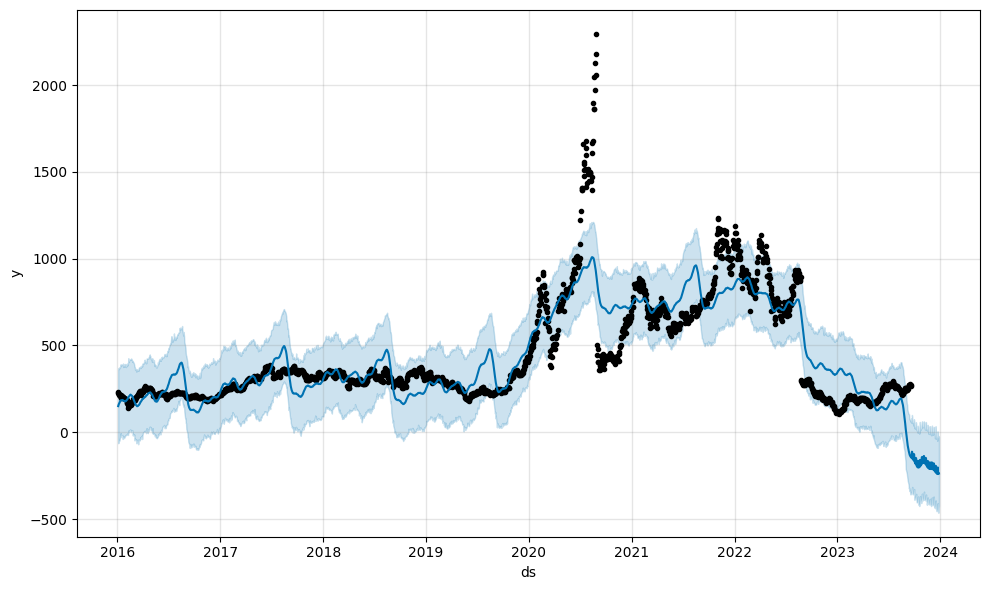

In [177]:
res = s3.get_object(Bucket=s3_bucket, Key=f'{s3_model_prefix}/TSLA_model.json')
m = model_from_json(res['Body'].read().decode('utf-8'))

future = m.make_future_dataframe(periods=100)
forecast = m.predict(future)
plot = m.plot(forecast)

## Prophet Approach

In [41]:
def display_forecast(df, periods, plot_only=True):
    m = Prophet()
    m.add_country_holidays(country_name='US')

    df_train, df_test = df.iloc[0:1920], df.iloc[1920:]

    x = df_train[['timestamp', 'open']].rename(columns={'timestamp': 'ds', 'open': 'y'})
    x['ds'] = x['ds'].dt.strftime('%Y-%m-%d')

    y = df_test[['timestamp', 'open']].rename(columns={'timestamp': 'ds', 'open': 'y'})
    y['ds'] = y['ds'].dt.strftime('%Y-%m-%d')

    m.fit(x)
    future = m.make_future_dataframe(periods=periods)
    forecast = m.predict(future)
    plot = m.plot(forecast)
    
    return None if plot_only else (m, forecast)

ticker = 'AAPL'
m, forecast = display_forecast(dataset[dataset['symbol'] == ticker], periods=365, plot_only=False)

In [43]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2280,2024-09-14,167.660932,86.223926,241.599945
2281,2024-09-15,167.144593,89.404040,250.748104
2282,2024-09-16,158.287801,79.067560,236.159944
2283,2024-09-17,158.718829,79.337566,234.464331
2284,2024-09-18,158.681993,76.509658,237.721722


In [192]:
fig = plot_plotly(m, forecast)
html = fig.to_html(full_html=False, 
                   config={'displayModeBar': False, 'responsive': True},
                   include_plotlyjs='cdn',
                   default_width='100%',
                   default_height='100%')

In [191]:
# with open('plot.html', 'r', encoding='utf-8') as file:
#     html_string = file.read()

s3.put_object(
    Bucket=s3_bucket,
    Key="plots/plot.html",
    Body=html,
    CacheControl="max-age=0,no-cache,no-store,must-revalidate",
    ContentType="text/html")

{'ResponseMetadata': {'RequestId': 'VFKEBXT0FB16Y92C',
  'HostId': 'QqCmtvw3LDlzUWMcvAD0Z/f0m10y7lD2Yqzg4jGb0KCblf1Ue1KSj1Mw2P/8YyTUD3J4pZo42tE=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'QqCmtvw3LDlzUWMcvAD0Z/f0m10y7lD2Yqzg4jGb0KCblf1Ue1KSj1Mw2P/8YyTUD3J4pZo42tE=',
   'x-amz-request-id': 'VFKEBXT0FB16Y92C',
   'date': 'Thu, 21 Sep 2023 21:35:47 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"58931fc21597b0ca7c9467dcb845c7fb"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"58931fc21597b0ca7c9467dcb845c7fb"',
 'ServerSideEncryption': 'AES256'}

In [44]:
with open('../AAPL_model.json', 'w') as fout:
    fout.write(model_to_json(m))

In [48]:
wr.s3.upload(local_file='../AAPL_model.json', path='s3://s3-alpaca-stock-data/prophet-models/AAPL_model.json', boto3_session=session)

In [105]:
# wr.s3.read_json(path=['s3://s3-alpaca-stock-data/prophet-models/AAPL_model.json'], boto3_session=session)
response = s3.get_object(Bucket='s3-alpaca-stock-data', Key='prophet-models/AAPL_model.json')
json_data = response['Body'].read().decode('utf-8')
json.loads(json_data)

''

## LSTM Approach

In [86]:
dataset_train, dataset_test = dataset.iloc[0:1920], dataset.iloc[1920:]

training_set = dataset_train.iloc[:, 3:4].values

In [73]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [78]:
X_train = []
y_train = []

for i in range(60, training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [80]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
59/59 [==============================] - 6s 44ms/step - loss: 0.0181
Epoch 2/100
59/59 [==============================] - 3s 45ms/step - loss: 0.0095
Epoch 3/100
59/59 [==============================] - 3s 48ms/step - loss: 0.0059
Epoch 4/100
59/59 [==============================] - 3s 47ms/step - loss: 0.0057
Epoch 5/100
59/59 [==============================] - 3s 47ms/step - loss: 0.0054
Epoch 6/100
59/59 [==============================] - 3s 47ms/step - loss: 0.0047
Epoch 7/100
59/59 [==============================] - 3s 47ms/step - loss: 0.0045
Epoch 8/100
59/59 [==============================] - 4s 60ms/step - loss: 0.0042
Epoch 9/100
59/59 [==============================] - 3s 49ms/step - loss: 0.0040
Epoch 10/100
59/59 [==============================] - 3s 49ms/step - loss: 0.0043
Epoch 11/100
59/59 [==============================] - 3s 53ms/step - loss: 0.0038
Epoch 12/100
59/59 [==============================] - 4s 63ms/step - loss: 0.0042
Epoch 13/100
59/59 [=====